In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(alpha=[0.1, 0.2],
                                 D0=[2.4, 2.5, 2.6])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
N = 16000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = 3
D_ = 2
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [4]:
#Set tasks
R = 2
gamma = 0.99
alpha = params['alpha']
D_ = 2
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
#g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * D_
g = np.sqrt(alpha * R * np.mean(D**2))
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance_block_haar(R=R,
                                                                                            gamma=gamma,
                                                                                            report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)

freq = 0.25
theta0 = np.arctan(freq)
D0 = params['D0']
Cs = np.transpose(sigma_mn_all, axes=(2,0,1))
real_freq = gamma * np.cos(theta0)
i_mode = np.argmin(np.abs(np.amax(np.linalg.eigvals(Cs).real, 1) - real_freq))
D_changed = D.copy()
D_changed[i_mode] = D0

0


In [109]:
#lags window
dt = 0.05
T_window_emp = 200
dT_emp = 0.05
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)
C_x_emp_avg = 0
N_W_samples = 5
for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=1020, dt_save=dT_emp, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=20, noise_series=None)
    x = torch.from_numpy(x).type(torch.FloatTensor).to(0)
    C_x_emp = compute_lagged_xcov(x[:,None,:], x[:,None,:], lags_emp, dt_save=dT_emp)
    
    C_x_emp_avg += C_x_emp / N_W_samples

In [69]:
#!/usr/bin/env python3
# Minimal fixed-point solver for the spontaneous state (Haar ensemble)
# Variables: Cx(ω), Cphi(ω), avg_gain = ⟨ϕ'⟩
# Based on equations (109)-(116) in the PDF, with erf(√π x / 2).
#
# We iterate:
#   1) IFFT Cx -> Cx(τ), get q = Cx(0)
#   2) avg_gain = 1/sqrt(1 + (π/2) q)        [closed-form for erf slope]
#   3) ρ(τ) = Cx(τ)/q  (if q<=0, bail to small positive)
#   4) Cphi(τ) = (2/π) * arcsin( ((π/2) q ρ)/(1 + (π/2) q) )   [Gaussian erf mapping]
#   5) FFT Cphi -> Cphi(ω)
#   6) Update Cx(ω) via (116): Cx(ω) = g_eff^2 * Cphi(ω) / [ 1 - (γ D avg_gain)^2 + ω^2 ]
#   7) Check convergence of q (or entire spectrum)
#
# Notes:
# - Uniform D, no M/N scaling in the sum; α and R only appear through g_eff = sqrt(α R) * D.
# - If you already define `g` in your main, set g_eff = g and ignore α,R,D relation.
# - All FFTs use numpy's conventions; time window T and N control ω grid: ω_k = 2π k / T.
#
# Author: ChatGPT (stripped down, no classes)

import numpy as np
import math

def angular_frequencies(N, T):
    dt = T / N
    f = np.fft.fftfreq(N, d=dt)          # cycles per unit time
    w = 2.0 * np.pi * f                  # angular frequency
    return w

def erf_gain_from_q(q):
    # phi(x) = erf(√π x / 2) => a = √π/2
    # ⟨ϕ'⟩ = (2a/√π)/sqrt(1 + 2 a^2 q). Here 2a/√π = 1, 2 a^2 = π/2.
    return 1.0 / math.sqrt(1.0 + (math.pi/2.0) * max(q, 0.0))

def Cphi_from_Cx_time(Cx_tau):
    # Map Cx(τ) -> Cphi(τ) using closed-form arcsin for erf.
    # Cphi = (2/π) * arcsin( ((π/2) q ρ) / (1 + (π/2) q) )
    q = float(Cx_tau[0])
    if q <= 0:
        q = 1e-9
    rho = Cx_tau / q
    num = (math.pi/2.0) * q * rho
    den = 1.0 + (math.pi/2.0) * q
    t = np.clip(num / den, -1.0, 1.0)
    return (2.0 / math.pi) * np.arcsin(t)

def solve_spontaneous(
    N=1200, T=60.0,
    alpha=0.5, R=2, D_bulk=2.0, gamma=0.99,
    g=None,                      # if provided, g_eff := g; else g_eff := sqrt(alpha*R)*D
    max_iters=500, tol=1e-9, mix=0.5
):
    # grids
    w = angular_frequencies(N, T)
    half = N//2 + 1

    # decide g_eff
    if g is None:
        g_eff = math.sqrt(alpha * R) * D_bulk
        
    else:
        g_eff = float(g)

    # initialize Cx(ω): small flat spectrum
    Cx_w = np.full(N, 1e-6, dtype=float)

    last_q = None
    for it in range(max_iters):
        # IFFT to time domain
        Cx_tau = np.fft.ifft(Cx_w).real
        q = float(Cx_tau[0])

        # avg gain
        gain = erf_gain_from_q(q)

        # map to Cphi(τ)
        Cphi_tau = Cphi_from_Cx_time(Cx_tau)

        # FFT back
        Cphi_w = np.fft.fft(Cphi_tau).real

        # update per Eq. (116): Cx(ω) = g_eff^2 * Cphi(ω) / [ 1 - (γ D ⟨ϕ′⟩)^2 + ω^2 ]
        denom_const = 1.0 - (gamma * D_bulk * gain)**2
        denom = denom_const + w*w
        denom = np.maximum(denom, 1e-12)   # numeric guard
        Cx_new_w = (g_eff**2) * (Cphi_w / denom)

        # simple under-relaxed mixing
        Cx_w = (1.0 - mix) * Cx_w + mix * Cx_new_w

        # convergence check on q and spectrum
        Cx_tau_new = np.fft.ifft(Cx_w).real
        q_new = float(Cx_tau_new[0])
        dq = abs(q_new - q)
        err_spec = np.linalg.norm(Cx_new_w - Cx_w) / (np.linalg.norm(Cx_w) + 1e-12)

        if last_q is not None and max(dq, err_spec) < tol:
            break
        last_q = q_new

    out = {
        "Cx_w": Cx_w,
        "Cphi_w": Cphi_w,
        "Cx_tau": Cx_tau_new,
        "Cphi_tau": Cphi_tau,
        "w": w,
        "q": q_new,
        "gain": gain,
        "g_eff": g_eff,
        "iters": it+1,
        "denom_const": denom_const,
    }
    return out

# Example run
res = solve_spontaneous(
    N=4000, T=100.0,
    alpha=alpha, R=2, D_bulk=2.0, gamma=0.99,
    g=None, max_iters=3000, tol=1e-8, mix=0.5
)


TypeError: only length-1 arrays can be converted to Python scalars

In [79]:
import numpy as np, math

def wgrid(N, T):
    dt = T / N
    return 2.0 * np.pi * np.fft.fftfreq(N, d=dt)

def erf_gain(q):
    return 1.0 / math.sqrt(1.0 + (math.pi/2.0) * max(q, 0.0))

def Cphi_from_Cx(Cx_tau):
    q = float(Cx_tau[0]);  q = max(q, 1e-12)
    rho = Cx_tau / q
    t = ((math.pi/2.0) * q * rho) / (1.0 + (math.pi/2.0) * q)
    t = np.clip(t, -1.0, 1.0)
    return (2.0/np.pi) * np.arcsin(t)

def solve_condensed(
    N=4096, T=200.0,
    alpha=1.0, R=2,
    D_bulk=2.0, D0=3.0,
    gamma=0.99, omega_star=0.6,
    g=None, mix=0.25, iters=800, tol=1e-9
):
    # grids
    w = wgrid(N, T)
    t = np.arange(N) * (T / N)
    cos_theta = 1.0 / math.sqrt(1.0 + omega_star**2)

    res_spont = solve_spontaneous(N=N, T=T,
                                  alpha=alpha, R=R, D_bulk=D_bulk, gamma=gamma,
                                  g=None,                      # if provided, g_eff := g; else g_eff := sqrt(alpha*R)*D
                                  max_iters=500, tol=1e-9, mix=0.5)
    
    # feasibility checks
    if gamma * D0 * cos_theta * res_spont['gain'] <= 1.0:
        #print("No condensed solution: need gamma*D0*cos(theta*) <phi'> > 1.")
        res_spont['spont'] = True
        return res_spont

    # target q from marginality
    q_target = (2.0/math.pi) * ((gamma*D0*cos_theta)**2 - 1.0)

    # effective bulk coupling
    g_eff = math.sqrt(alpha * R) * D_bulk if g is None else float(g)

    # init
    S_noise = np.full(N, 1e-6, dtype=float)

    last_q = None
    for k in range(iters):
        # noise-only covariance
        Cx_noise = np.fft.ifft(S_noise).real
        q_noise = float(Cx_noise[0])

        # set coherent amplitude to hit marginality exactly
        P = max(0.0, q_target - q_noise)

        # total covariance in time
        Cx_tau = Cx_noise + P * np.cos(omega_star * t)

        # gain from total q
        q = float(Cx_tau[0])
        gain = erf_gain(q)

        # nonlinear mapping
        Cphi_tau = Cphi_from_Cx(Cx_tau)
        Sphi = np.fft.fft(Cphi_tau).real

        # bulk transfer (uses D_bulk and current gain)
        denom0 = 1.0 - (gamma * D_bulk * gain)**2  # should be >0 by feasibility
        denom = np.maximum(denom0 + w*w, 1e-14)

        S_pred = (g_eff**2) * (Sphi / denom)

        # remove coherent part in freq (computed numerically)
        Scoh = np.fft.fft(P * np.cos(omega_star * t)).real

        S_noise_new = np.maximum(S_pred - Scoh, 0.0)

        # conservative mixing (helps conditioning near ω=0)
        S_noise = (1.0 - mix) * S_noise + mix * S_noise_new

        # convergence: spectrum + q
        Cx_noise_new = np.fft.ifft(S_noise).real
        q_noise_new = float(Cx_noise_new[0])
        q_total_new = q_noise_new + P
        dq = abs(q_total_new - q)
        dspec = np.linalg.norm(S_noise_new - S_noise) / (np.linalg.norm(S_noise) + 1e-12)
        if last_q is not None and max(dq, dspec) < tol:
            break
        last_q = q_total_new

    return dict(
        iters=k+1, w=w, t=t,
        S_noise=S_noise, P=P,
        Cx_tau=Cx_noise_new + P*np.cos(omega_star*t),
        q=q_total_new, gain=erf_gain(q_total_new),
        g_eff=g_eff, q_target=q_target, denom0=denom0,
        spont=False
    )

Text(0.5, 1.0, '0.04')

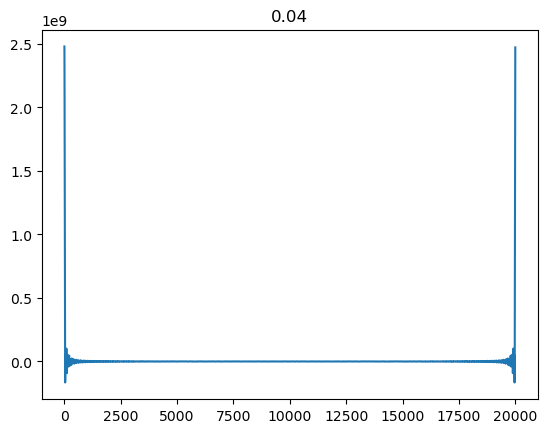

In [131]:
gamma = 0.99
D_bulk = 2
T = 12000
N_bins = 20000
omega_star = 0.25
gamma = 0.99
i_min = np.argmin(np.abs(2*np.pi*np.fft.fftfreq(N_bins, T/N_bins) - omega_star))
omega_star = 2*np.pi*np.fft.fftfreq(N_bins, T/N_bins)[i_min]
cos_theta = 1.0 / math.sqrt(1.0 + omega_star**2)

alpha = 0.04
res = solve_condensed(
    N=N_bins, T=T,
    alpha=alpha, R=2,
    D_bulk=D_bulk,   # ensure D_bulk < D0*cosθ*
    D0=2,
    gamma=gamma, omega_star=omega_star,
    g=None, mix=0.25, iters=3000, tol=1e-9
)
plt.figure()
plt.plot(res['Cx_tau'])
plt.title(alpha)

In [62]:
i_T_period = int(2*np.pi/omega_star/0.05)

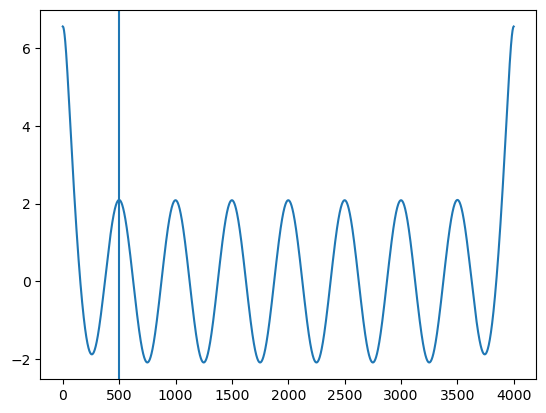

In [65]:
plt.plot(res['Cx_tau'])
plt.axvline(x=i_T_period)

In [80]:
alpha_vals = np.linspace(0.08, 1.0, 20)
D0_vals = np.linspace(2.0, 5.0, 20)
phase = np.zeros((len(alpha_vals), len(D0_vals)), dtype=int)
N_bins = 4000
T = 200
omega_star = 0.25
gamma = 0.99
i_min = np.argmin(np.abs(2*np.pi*np.fft.fftfreq(N_bins, T/N_bins) - omega_star))
omega_star = 2*np.pi*np.fft.fftfreq(N_bins, T/N_bins)[i_min]
cos_theta = 1.0 / math.sqrt(1.0 + omega_star**2)
i_T_period = int(2*np.pi/omega_star/0.05)
for i_alpha, alpha in enumerate(alpha_vals):
    for i_D0, D0 in enumerate(D0_vals):
        res = solve_condensed(
            N=N_bins, T=T,
            alpha=alpha, R=2,
            D_bulk=2,   # ensure D_bulk < D0*cosθ*
            D0=D0,
            gamma=gamma, omega_star=omega_star,
            g=None, mix=0.25, iters=3000, tol=1e-9
        )
        
        if res['spont']:
            phase[i_alpha, i_D0] = 0
        else:
            Cx = res['Cx_tau']
            if (Cx[0] - Cx[i_T_period])/Cx[0] < 0.02:
                phase[i_alpha, i_D0] = 1
            else:
                phase[i_alpha, i_D0] = 2
           

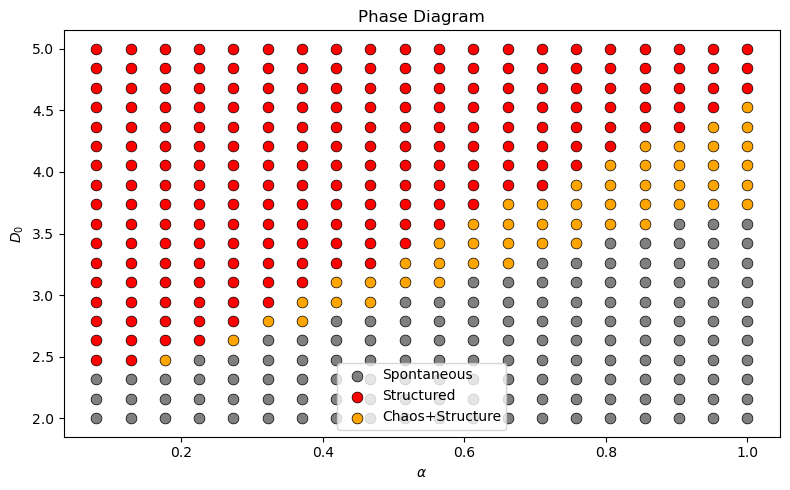

In [83]:
# plot phase diagram (transposed axes)
cmap = {0: "gray", 1: "red", 2: "orange"}

plt.figure(figsize=(8, 5))
for key, color in cmap.items():
    ii, jj = np.where(phase == key)  # ii: alpha index, jj: D0 index
    plt.scatter(alpha_vals[ii], D0_vals[jj],
                c=color,
                label={0:"Spontaneous",1:"Structured",2:"Chaos+Structure"}[key],
                s=60, edgecolors='k', linewidths=0.5)

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$D_0$")
plt.title("Phase Diagram")
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
alpha_vals

(array([0.05      , 0.15555556, 0.26111111, 0.36666667, 0.47222222,
        0.57777778, 0.68333333, 0.78888889, 0.89444444, 1.        ]),)

In [111]:
#processed_data = np.array([D_crit_omega, D0, chaos_index])
CX_emp = C_x_emp_avg.cpu().numpy().squeeze().mean(-1)
processed_data = np.array([CX_emp, res['Cx_tau']])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [150]:
###Truncate file above
file_name = 'Figure_S2_small_alpha_condensed'
job_name = 'check_condensed_theory_2'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Figure_S2_small_alpha_condensed.ipynb to script
[NbConvertApp] Writing 69172 bytes to Figure_S2_small_alpha_condensed.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac65ac715d0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac65ac715d0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [151]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='Multi_Task_Elife')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='Multi_Task_Elife', lkumar=False)

sending incremental file list

sent 2,002 bytes  received 31 bytes  4,066.00 bytes/sec
total size is 502,265  speedup is 247.06
sbatch  --array=1-60 /home/om2382/low-rank-dims/job_scripts/check_condensed_theory_2.s


In [153]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           5255970    lkumar  jupyter   om2382  R    4:37:01      1 ax14
        5256727_29     burst check_co   om2382  R      30:54      1 ax04
        5256727_30     burst check_co   om2382  R      30:54      1 ax05


In [154]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'check_condensed_theory_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

In [155]:
theory_results[0]

{'alpha': [0.1, 0.2],
 'D0': [2.4, 2.5, 2.6],
 'i_seed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

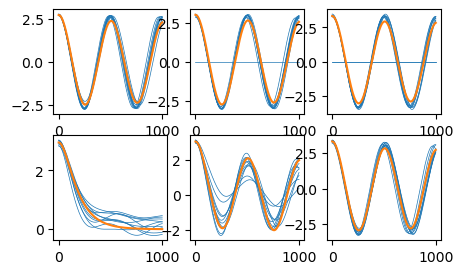

In [160]:
fig, ax = plt.subplots(2, 3, figsize=(5, 3))
for i in range(2):
    for j in range(3):
        for i_seed in range(10):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:1000], color='C0', linewidth=0.5)
        ax[i,j].plot(theory_results[1][i,j,0,1,:1000], color='C1')
        

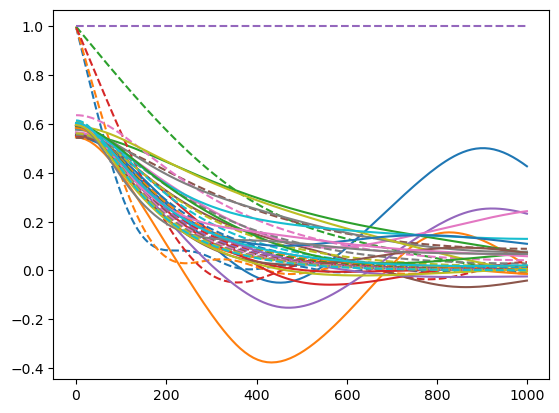

In [131]:
for i_alpha in range(20):
    plt.plot(theory_results[1][i_alpha, 0, 0, :1000], color='C{}'.format(i_alpha))
    plt.plot(theory_results[1][i_alpha, 0, 1, :2000:2], color='C{}'.format(i_alpha), linestyle='--')
    

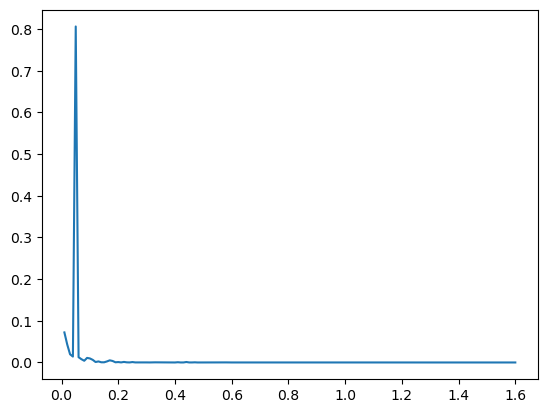

In [132]:
C_emp = theory_results[1][:, 0, 0, :1000]
C_theory = theory_results[1][:, 0, 1, :2000:2]
error = np.square(C_emp - C_theory).mean(-1)
plt.plot(theory_results[0]['alpha'], error)

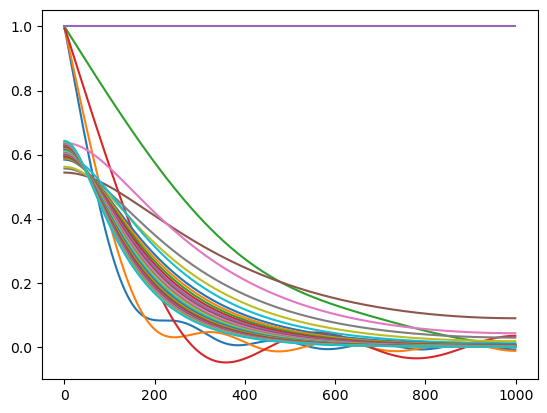

In [123]:
for i in range(30):
    plt.plot(C_theory[i])

In [170]:
import math
from dataclasses import dataclass

@dataclass
class BulkVarianceVerdict:
    feasible_condensed: bool      # gamma*D0*cosθ* > 1 ?
    bulk_subcritical: bool        # δ_bulk > 0 ?
    bulk_gap_delta: float         # δ_bulk = 1 - (D_bulk/(D0*cosθ*))**2
    avg_gain_at_condensed: float  # <phi'> = 1/(gamma*D0*cosθ*)
    cos_theta_star: float         # cosθ* = 1/sqrt(1+omega_star**2)
    alpha_eff: float              # M_eff/N you chose (often (M-1)/N)
    ideal_bulk_variance: float    # always 0.0 in ideal harmonic-split theory
    verdict: str                  # human-readable summary

def bulk_variance_check(alpha: float, R: float,
                        D_bulk: float, D0: float,
                        omega_star: float, gamma: float,
                        alpha_eff: float = None) -> BulkVarianceVerdict:
    """
    Decide if the bulk should contribute any variance in the *ideal* condensed theory
    for a given frequency omega_star. In the ideal harmonic split, the answer is 0
    whenever a condensed state exists and the bulk is subcritical.
    
    alpha, R appear only in g_eff for the noise channel in full DMFT; they do not
    change the YES/NO verdict in the ideal split. You can pass alpha_eff=(M-1)/N
    if you want to keep it for bookkeeping; default uses alpha.
    """
    cos_theta = 1.0 / math.sqrt(1.0 + omega_star**2)
    feasible = (gamma * D0 * cos_theta) > 1.0
    if not feasible:
        return BulkVarianceVerdict(
            feasible_condensed=False,
            bulk_subcritical=False,
            bulk_gap_delta=float('nan'),
            avg_gain_at_condensed=float('inf'),
            cos_theta_star=cos_theta,
            alpha_eff=alpha if alpha_eff is None else alpha_eff,
            ideal_bulk_variance=float('nan'),
            verdict="No condensed solution: gamma*D0*cos(theta*) <= 1."
        )

    # Gain pinned by marginality of the outlier:
    avg_gain = 1.0 / (gamma * D0 * cos_theta)

    # Bulk zero-frequency gap:
    delta_bulk = 1.0 - (D_bulk / (D0 * cos_theta))**2
    bulk_ok = delta_bulk > 0.0

    # Ideal verdict:
    if bulk_ok:
        vtxt = ("Condensed solution exists and bulk is strictly subcritical "
                f"(delta_bulk={delta_bulk:.3g}). In the ideal harmonic-split "
                "theory, bulk variance = 0 (all coherent power is assigned to the "
                "condensed mode, no continuous-frequency drive to the bulk).")
        ideal_var = 0.0
    else:
        vtxt = ("Bulk is marginal/unstable under the condensed gain "
                f"(delta_bulk={delta_bulk:.3g} <= 0): stationary bulk variance "
                "does not exist (diverges).")
        ideal_var = float('inf')

    return BulkVarianceVerdict(
        feasible_condensed=True,
        bulk_subcritical=bulk_ok,
        bulk_gap_delta=delta_bulk,
        avg_gain_at_condensed=avg_gain,
        cos_theta_star=cos_theta,
        alpha_eff=alpha if alpha_eff is None else alpha_eff,
        ideal_bulk_variance=ideal_var,
        verdict=vtxt
    )

# Example:
verdict = bulk_variance_check(alpha=0.1, R=2, D_bulk=2.0, D0=12, omega_star=0.25, gamma=0.99, alpha_eff=0.0)
print(verdict.verdict)
# print(vars(verdict))

Condensed solution exists and bulk is strictly subcritical (delta_bulk=0.97). In the ideal harmonic-split theory, bulk variance = 0 (all coherent power is assigned to the condensed mode, no continuous-frequency drive to the bulk).


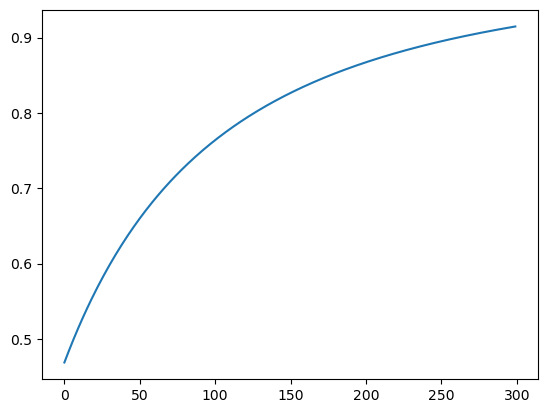

In [172]:
D0_ = np.arange(2, 5, 0.01)
plt.plot(1 - (2/(D0_ * np.cos(theta0))**2))

In [221]:
import numpy as np

def structured_chaos_criterion(alpha, R, D_bulk, D0, omega_star, gamma,
                               wmax=50.0, nfreq=10000):
    """
    Determine if the condensed oscillation (D0, omega_star) at gain gamma
    admits a stable q=0 bulk fixed point (pure structure) or if a chaotic
    bulk variance branch bifurcates (structured chaos).

    Nonlinearity: phi(x) = erf(sqrt(pi)/2 * x)
    """
    # --- 1. condensed gain and oscillation amplitude p ---
    cos_th = 1.0 / np.sqrt(1.0 + omega_star**2)
    g_cond = 1.0 / (D0 * cos_th)   # value of gamma*<phi'> required by marginality

    # Solve for p from gamma / sqrt(1+π/2 p) = 1/(D0 cosθ*)
    rhs = 1.0 / (D0 * cos_th)
    p = (2.0 / np.pi) * ((gamma * D0 * cos_th)**2 - 1.0)
    if p <= 0:
        return {
            "p": p,
            "lambda_bulk": None,
            "regime": "no_condensed_solution"
        }

    # --- 2. linearization eigenvalue of bulk variance map at q=0 ---
    # For erf nonlinearity, the derivative of S_phi wrt q at q=0
    # is related to derivative of autocovariance. For simplicity, we approximate
    # it by linearizing the Gaussian drive spectrum.
    #
    # For a stationary Gaussian process with variance p, phi(x) has autocov
    # C_phi(τ) = (2/π) * arcsin( π/2 * C_x(τ)/(1+π/2 p) )
    # Linearization wrt q at q=0 is basically derivative wrt variance around p.
    #
    # Here we'll approximate dS_phi/dq as the derivative of the *zero-frequency*
    # gain part, which dominates the bulk transition (Rajan 2010).

    # zero-frequency derivative of <phi'(x)^2> wrt q (erf case)
    # For erf, the relevant factor for chaos onset is F'(p) = γ^2 * (π/2)/(1+π/2 p)^2
    Fprime = (gamma**2) * (np.pi/2.0) / (1.0 + (np.pi/2.0)*p)**2

    # Bulk eigenvalue λ = α R D_bulk^2 * F'(p) / (1 - (g_cond D_bulk)^2)
    denom0 = 1.0 - (g_cond * D_bulk)**2
    lam_bulk = alpha * R * D_bulk**2 * Fprime / denom0

    regime = "structure+chaos" if lam_bulk > 1.0 else "pure_structure"

    return {
        "p": p,
        "lambda_bulk": lam_bulk,
        "regime": regime
    }


# Example usage:
if __name__ == "__main__":
    alpha = 0.2
    R = 2
    D_bulk = 2.0
    D0 = 2.15
    omega_star = 0.25
    gamma = 0.99

    result = structured_chaos_criterion(alpha, R, D_bulk, D0, omega_star, gamma)
    print(result)

{'p': 2.077934276859278, 'lambda_bulk': 1.6812184640646801, 'regime': 'structure+chaos'}


In [222]:
res = solve_spontaneous(
                    N=4000, T=200.0,
                    alpha=0.2, R=2, D=2, gamma=0.99,
                    g=None, max_iters=1000, tol=1e-8, mix=0.5
                )

In [224]:
1/(gamma * cos_th * res['gain'])

2.472273783049231

In [207]:
alphas = np.arange(0.1, 1, 0.01)
D0s = np.arange(2, 5, 0.025)
regime = np.zeros((len(alphas), len(D0s)))
for i_alpha, alpha in enumerate(alphas):
    res = solve_spontaneous(
                        N=4000, T=200.0,
                        alpha=alpha, R=2, D=2, gamma=0.99,
                        g=None, max_iters=1000, tol=1e-8, mix=0.5
                    )
    print(i_alpha)
    for i_D0, D0 in enumerate(D0s):
        result = structured_chaos_criterion(alpha=alpha, R=2, D_bulk=2, D0=D0, omega_star=0.25, gamma=0.99)
        cos_th = 1.0 / np.sqrt(1.0 + omega_star**2)
        #if D0 < 1/(gamma*cos_th*res['gain']):
        #    regime[i_alpha, i_D0] = 0
        if result['regime'] == 'pure_structure':
            regime[i_alpha, i_D0] = 2
        elif result['regime'] == 'structure+chaos':
            regime[i_alpha, i_D0] = 1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


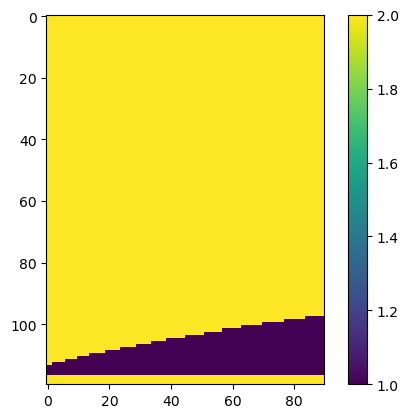

In [220]:
regime_ = np.flip(regime.T, axis=0)
plt.imshow(regime_)
plt.colorbar()
D0s = np.round(D0s, 2)
#plt.xlim([10, 30])
#plt.ylim([120, 80])
#plt.yticks([0, 40, 80], [D0s[0], D0s[40], D0s[80]])

In [182]:
cos_th = 1.0 / np.sqrt(1.0 + omega_star**2)

In [10]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
i_D = 2
R = 2
D_ = theory_results[0]['D'][i_D]
g_eff = np.sqrt(np.array(theory_results[0]['alpha']) * R * D_**2)
fig = plt.figure(figsize=(4, 4))
plt.plot(theory_results[0]['alpha'], theory_results[1][:,i_D,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['alpha'], theory_results[1][:,i_D,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['alpha'],
                 np.zeros_like(theory_results[0]['alpha']),
                 theory_results[1][:,i_D,0,0], color=col1)
plt.fill_between(theory_results[0]['alpha'],
                 theory_results[1][:,i_D,0,0],
                 theory_results[1][:,i_D,0,1], color=col2)
plt.fill_between(theory_results[0]['alpha'],
                 theory_results[1][:,i_D,0,1],
                 4*np.ones_like(theory_results[0]['alpha']), color=col3)
plt.axvline(theory_results[0]['alpha'][np.where(g_eff>1)[0][0]])
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
#plt.xlim([0, 2])
#plt.ylim([0, 13])
#plt.xlim([0.1, 4])
#plt.xscale('log')
#plt.xlabel('frequency of condensed pattern')
#plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])
#plt.xlim([0.1, 0.2])
#print(theory_results[0]['freq'][6])
#plt.axvline(x=theory_results[0]['freq'][6])

KeyError: 'D'

(0.0, 8.0)

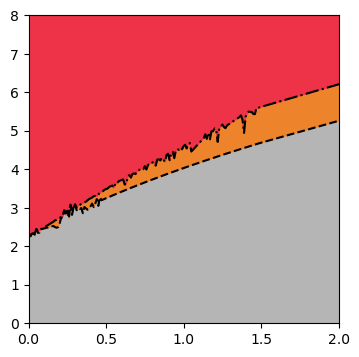

In [19]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
i_crit = 3
fig = plt.figure(figsize=(4, 4))
plt.plot(theory_results[0]['alpha'], theory_results[1][:,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['alpha'], theory_results[1][:,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['alpha'],
                 np.zeros_like(theory_results[0]['alpha']),
                 theory_results[1][:,0,0], color=col1)
plt.fill_between(theory_results[0]['alpha'],
                 theory_results[1][:,0,0],
                 theory_results[1][:,0,1], color=col2)
plt.fill_between(theory_results[0]['alpha'],
                 theory_results[1][:,0,1],
                 8*np.ones_like(theory_results[0]['alpha']), color=col3)
#plt.axvline(theory_results[0]['alpha'][np.where(g_eff>1)[0][0]])
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.xlim([0, 2])
plt.ylim([0, 8])
#plt.ylim([0, 13])
#plt.xlim([0.1, 4])
#plt.xscale('log')
#plt.xlabel('frequency of condensed pattern')
#plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])
#plt.xlim([0.1, 0.2])
#print(theory_results[0]['freq'][6])
#plt.axvline(x=theory_results[0]['freq'][6])

In [197]:
R = 2
D_ = 1.1
g_eff = np.sqrt(np.array(theory_results[0]['alpha']) * R * D_**2)

In [199]:
np.where(g_eff > 1)

(array([ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144]),)

In [5]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
i_crit = 3
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], np.median(theory_results[1][:,:,0], -1), color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], np.median(theory_results[1][:,:,1], -1), color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 np.median(theory_results[1][:,:,0], -1), color=col1)
plt.fill_between(theory_results[0]['freq'],
                 np.median(theory_results[1][:,:,0], -1),
                 np.median(theory_results[1][:,:,1], -1), color=col2)
plt.fill_between(theory_results[0]['freq'],
                 np.median(theory_results[1][:,:,1], -1),
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 13])
#plt.xlim([0.1, 4])
plt.xscale('log')
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])
plt.xlim([0.1, 0.2])
print(theory_results[0]['freq'][6])
plt.axvline(x=theory_results[0]['freq'][6])

KeyError: 'freq'

<Figure size 400x200 with 0 Axes>

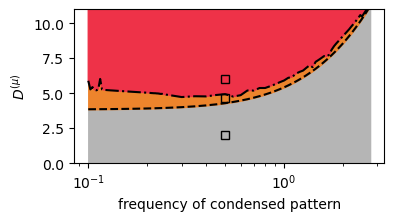

In [119]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
i_crit = 3
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], np.median(theory_results[1][:,:,0], -1), color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], np.median(theory_results[1][:,:,1], -1), color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 np.median(theory_results[1][:,:,0], -1), color=col1)
plt.fill_between(theory_results[0]['freq'],
                 np.median(theory_results[1][:,:,0], -1),
                 np.median(theory_results[1][:,:,1], -1), color=col2)
plt.fill_between(theory_results[0]['freq'],
                 np.median(theory_results[1][:,:,1], -1),
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 11])
#plt.xlim([0.1, 4])
plt.xscale('log')
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])
plt.plot([0.5], [2], marker='s', color='k', markerfacecolor='None')
plt.plot([0.5], [4.65], marker='s', color='k', markerfacecolor='None')
plt.plot([0.5], [6], marker='s', color='k', markerfacecolor='None')

Text(0, 0.5, '$D^{(\\mu)}$')

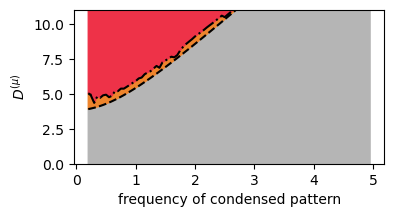

In [18]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
i_crit = 3
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], theory_results[1][:,i_crit,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], theory_results[1][:,i_crit,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 theory_results[1][:,i_crit,0,0], color=col1)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,i_crit,0,0],
                 theory_results[1][:,i_crit,0,1], color=col2)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,i_crit,0,1],
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 11])
#plt.xlim([0.1, 2])
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])

Text(0, 0.5, '$D^{(\\mu)}$')

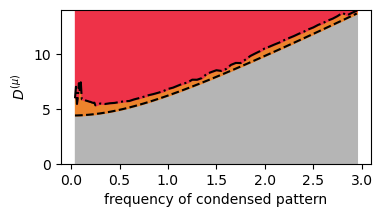

In [40]:
col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 theory_results[1][:,0,0], color=col1)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,0],
                 theory_results[1][:,0,1], color=col2)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,1],
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 14])
#plt.xlim([0.1, 2])
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])

Text(0, 0.5, '$D^{(\\mu)}$')

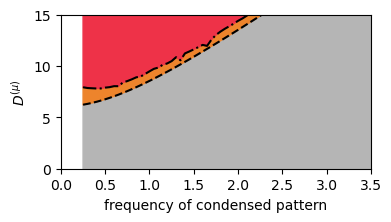

In [182]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'large_bifurfaction_frequencies_gamma_06'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

col1 = '#B5B5B5'
col2 = '#ED842C'
col3 = '#EE3248'
fig = plt.figure(figsize=(4, 2))
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0], color='k', linestyle='--')
plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1], color='k', linestyle='dashdot')
plt.fill_between(theory_results[0]['freq'],
                 np.zeros_like(theory_results[0]['freq']),
                 theory_results[1][:,0,0], color=col1)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,0],
                 theory_results[1][:,0,1], color=col2)
plt.fill_between(theory_results[0]['freq'],
                 theory_results[1][:,0,1],
                 25*np.ones_like(theory_results[0]['freq']), color=col3)
#plt.legend(['$D^{(\mu)}_{\mathrm{crit},1}$', '$D^{(\mu)}_{\mathrm{crit},2}$', 'spontaneous',
#            'structured chaos', 'deterministic'], loc='lower right')
plt.ylim([0, 15])
plt.xlim([0, 3.5])
plt.xlabel('frequency of condensed pattern')
plt.ylabel('$D^{(\mu)}$')
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,0])
#plt.ylim([5, 12])
#plt.plot(theory_results[0]['freq'], theory_results[1][:,0,1]/theory_results[1][:,0,0])
#plt.annotate('deterministic', xy=[2, 20])

In [203]:
with open('/home/om2382/low-rank-dims/results/Multi_Task_Elife/x_dim_theory_check/result_21', 'rb') as f:
    res = pickle.load(f)

In [4]:
theory_results[0]

{'N': [3000, 6000],
 'D_crit_factor': [1.0,
  1.01,
  1.02,
  1.03,
  1.04,
  1.05,
  1.06,
  1.07,
  1.08,
  1.09,
  1.1,
  1.11,
  1.12,
  1.13,
  1.14,
  1.15],
 'i_seed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

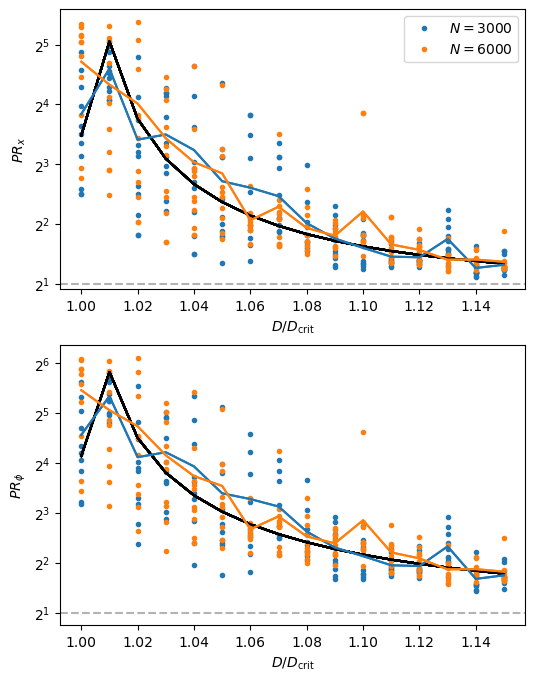

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,0,0],
             '.', alpha=1, color='C{}'.format(i))
for i in range(2):
    for i_seed in range(10):
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,3],
                 alpha=1, color='k')
for i in range(2):
    for i_ax in range(2):
        ax[i_ax].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
        ax[i_ax].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
#plt.yscale('log', base=2)
ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 3000$', '$N = 6000$'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
ax[0].axhline(y=2, linestyle='--', color=('0.7'))
ax[1].axhline(y=2, linestyle='--', color=('0.7'))
#ax[1].set_xscale('log', base=2)

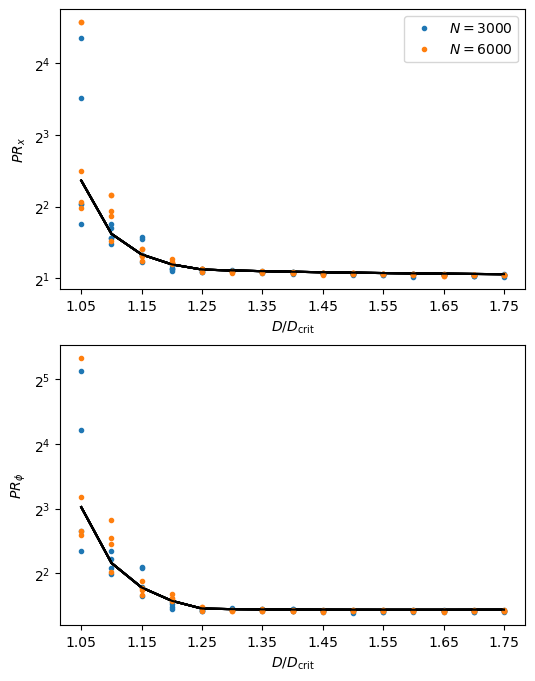

In [234]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,0,0],
             '.', alpha=1, color='C{}'.format(i))
for i in range(2):
    for i_seed in range(4):
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,3],
                 alpha=1, color='k')
#plt.yscale('log', base=2)
ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 3000$', '$N = 6000$'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
#ax[1].set_xscale('log', base=2)

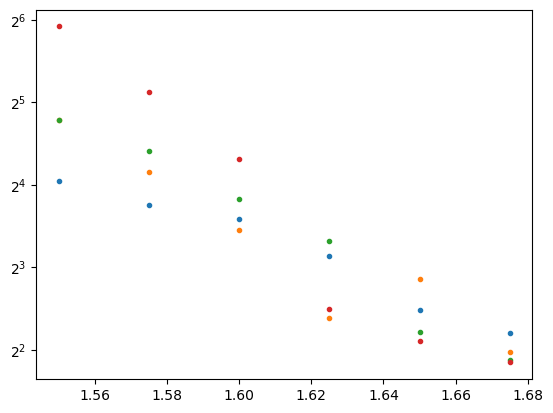

In [10]:
for i in range(4):
    plt.plot(theory_results[0]['D_1'],theory_results[1][i,:,:,0].mean(-1),
             '.', alpha=1, color='C{}'.format(i))
plt.yscale('log', base=2)

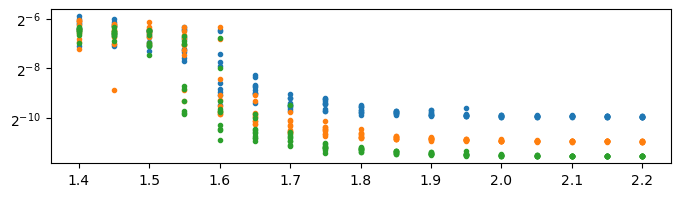

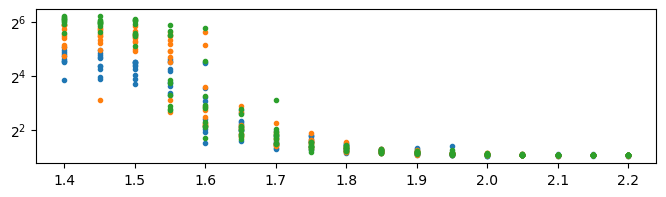

In [29]:
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    for i_seed in range(10):
        plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,i_seed,0]/N, '.', color='C{}'.format(i))
plt.yscale('log', base=2)
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    for i_seed in range(10):
        plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,i_seed,0], '.', color='C{}'.format(i))
plt.yscale('log', base=2)
#plt.yscale('log', base=2)
#plt.yticks([1, 2, 32])

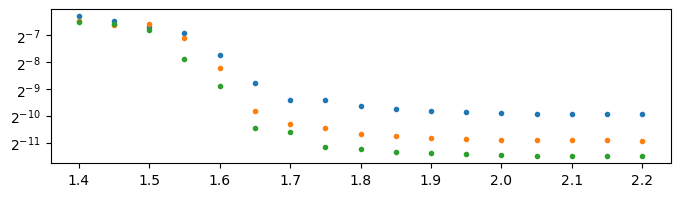

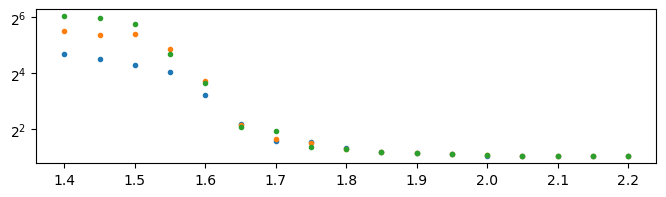

In [4]:
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,:,0].mean(1)/N, '.', color='C{}'.format(i))
plt.yscale('log', base=2)
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,:,0].mean(1), '.', color='C{}'.format(i))
plt.yscale('log', base=2)
#plt.yscale('log', base=2)
#plt.yticks([1, 2, 32])

(-0.04854065701365471, 0.47105365797857557)

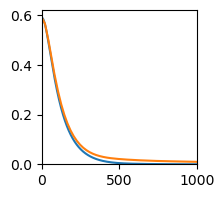

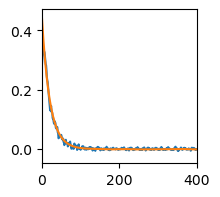

In [4]:
i_sym = 0
i_C_sigma = 0
i_PR_D = 2
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,2,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,3,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 1000])
ymax = np.amax(np.concatenate([theory, sim]))
plt.ylim([0, ymax * 1.05])
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,0,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,1,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 400])
ymax = np.amax(np.concatenate([theory, sim]))
ymin = np.amin(np.concatenate([theory, sim]))
plt.ylim([ymin, ymax * 1.05])

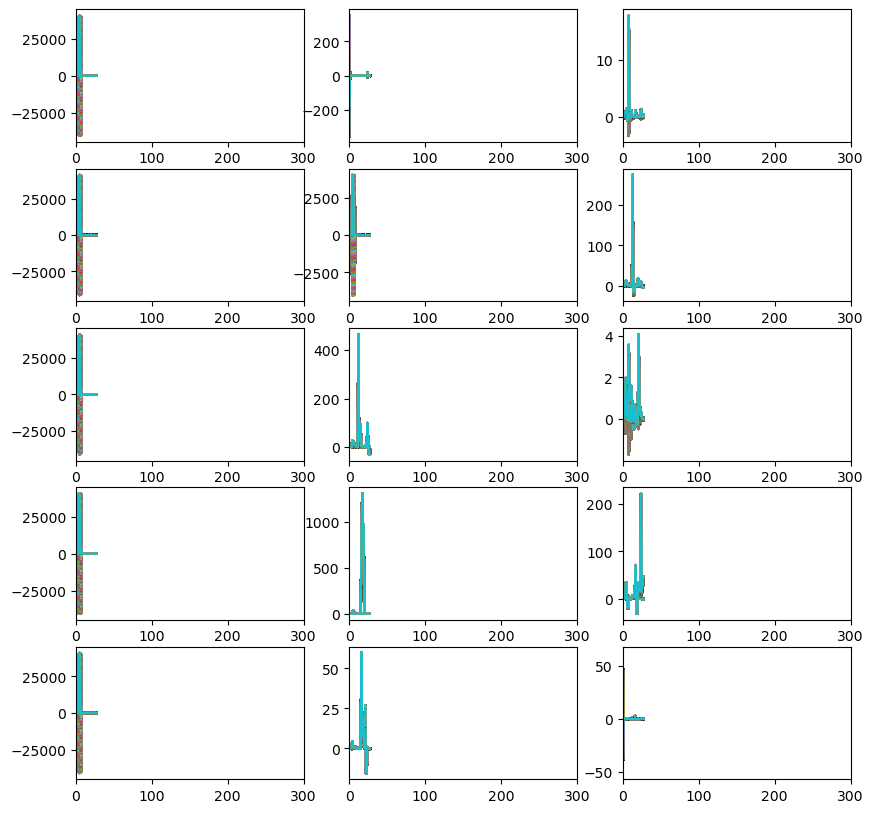

In [15]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,0,:])
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,1,:])
        ax[i_sym,i_g].set_xlim([0, 300])

In [ ]:
theory_results[1].shape
plt.plot(theory_results[1][0,0,0,2,:])
plt.plot(theory_results[1][0,0,0,3,:])
plt.xlim([0, 1000])

In [ ]:
#network properties size
#N = theory_results[0]['N'][i_N]

def get_activity(i_g, i_sym):
    #i_g = 0
    #i_sym = 0
    N = 5000
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    g = theory_results[0]['g'][i_g]
    #g = 5
    #lags window
    T_window_emp = 1
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)

    R = 2
    #alpha = theory_results[0]['alpha'][i_alpha]
    alpha = 0.5
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction

    sym = theory_results[0]['sym'][i_sym]
    sym = -1
    sigma_mn_all = np.zeros((R, R, N_tasks))
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                     sigma_off=0.6,
                                                                                     symmetry_factor=sym,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

    ### --- Estimate S empirically --- ###

    T_sim = 400
    dt = 0.05
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    
    return x, r, Z

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(x[:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(Z[0,:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [46]:
###### --- Plot basic transients --- ###

i_g = 0
i_sym = 0
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 0.3
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 300
dt = 0.05
x1, r1 = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200, noise_series=None)
x0 = torch.tensor(x1[-1]).to(0)[None,:]
m1 = torch.tensor(all_loadings[0,:,0]).to(0)
n1 = torch.tensor(all_loadings[0,:,2]).to(0)
x2, r2 = sample_activity(T_sim=5, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=300*m1)
x0 = torch.tensor(x2[-1]).to(0)[None,:]
#x0 = 300*n1[None,:]
x3, r3 = sample_activity(T_sim=200, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=None)

#x = np.concatenate([x1, x3], axis=0)
#r = np.concatenate([r1, r3], axis=0)
x = np.concatenate([x1, x2, x3], axis=0)
r = np.concatenate([r1, r2, r3], axis=0)
Z = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r) * D[:6,None,None]

In [40]:
np.savez('packaged_results/input_drive_transients.npz', Z=Z)

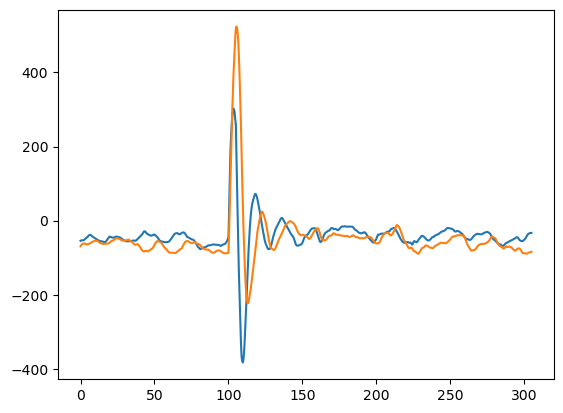

In [47]:
time_vec = np.arange(0, 305, dt)
plt.plot(time_vec, Z[0,:,0])
plt.plot(time_vec, Z[0,:,1])
#plt.xlim([50, 150])

In [75]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100000
dt = 0.1
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=False, T_save_delay=200, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

1060


In [3]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 10000
dt = 0.1
N_runs = 50
Zs = []
for i_run in range(N_runs):
    print(i_run)
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=False, T_save_delay=10, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    Zs.append(Z)
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

958
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
import numpy as np
import matplotlib.pyplot as plt

N = 4000

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, limit_cycle=None, plot_only_first=True, fp=None, Z_long=None,
                                     z_labels=None, sqrt_ticks=True, plot_arrows=False):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    fig = plt.figure(figsize=(5, 5))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1, zorder=2)
            if plot_arrows:
                # Compute directional differences between successive points
                dx = np.diff(z[:, 0])
                dy = np.diff(z[:, 1])
                speed = np.sqrt(dx**2 + dy**2)
                dx = dx/speed
                dy = dy/speed

                # Choose arrow placement interval (adjust based on your data density)
                arrow_interval = max(1, len(z) // 20)

                # Plot arrows using quiver. We use z[:-1] since np.diff returns one fewer element.
                plt.quiver(z[:-1:arrow_interval, 0], z[:-1:arrow_interval, 1],
                           dx[::arrow_interval], dy[::arrow_interval],
                           color='#AC85BC', scale_units='xy', angles='xy', scale=0.8,
                            width=0.008,         # Arrow shaft thickness
                            headwidth=15,         # Width of the arrow head
                            headlength=15,        # Length of the arrow head
                            headaxislength=15, zorder=3)

            
            if plot_only_first:
                break
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    if limit_cycle is not None:
        plt.plot(limit_cycle[:,0], limit_cycle[:,1], color='k', linestyle='--', linewidth=0.8)
    if fp is not None:
        for fp_ in fp:
            plt.plot([fp_[0]], [fp_[1]], 'x', color='k', markersize=3)
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=0.7)
    if z_labels==1:
        plt.xlabel('$z^{(1)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(1)}_2(t)$', fontsize=8)
    elif z_labels==2:
        plt.xlabel('$z^{(2)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(2)}_2(t)$', fontsize=8)
    else:
        plt.xlabel('$z_1(t)$', fontsize=8)
        plt.ylabel('$z_2(t)$', fontsize=8)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    if sqrt_ticks:
        plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
        plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
    else:
        pass
    plt.axis('equal')
    plt.show()
    
    return fig

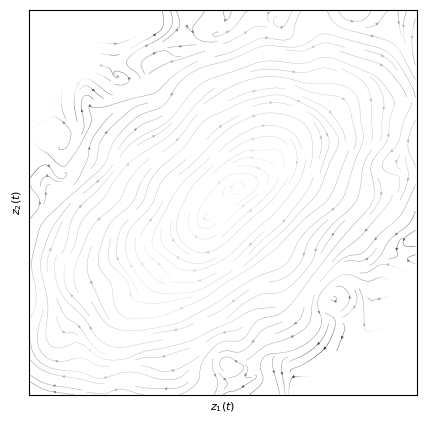

In [11]:
R = 15
x_range = (-R, R)
y_range = (-R, R)

all_batches = [zs[1] for zs in Zs]

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=0.3, arrowsize=0.4,
                                       Z=None, plot_only_first=False)

In [4]:
all_batches = Z[None,:0,:,:]

R = 2
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=None)

NameError: name 'compute_average_flow_field_cartesian_batches' is not defined

In [76]:
np.savez('packaged_results/MalphaN_limcyc_fp_2', Z=Z)

In [77]:
!du -sh packaged_results/MalphaN_limcyc_fp.npz

10M	packaged_results/MalphaN_limcyc_fp.npz


In [14]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

0


In [15]:
np.savez('packaged_results/M=1_network_3', Zs=Zs, Z_long=Z_long)

In [55]:
### --- M = 2 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 40
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1 + x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]

2


In [57]:
np.savez('packaged_results/M=2_network_limcyc_fp', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

In [58]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
#N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,0] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

1


In [59]:
np.savez('packaged_results/M=1_network_fp', Zs=Zs, Z_long=Z_long)

In [ ]:
### --- M = \alpha N network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

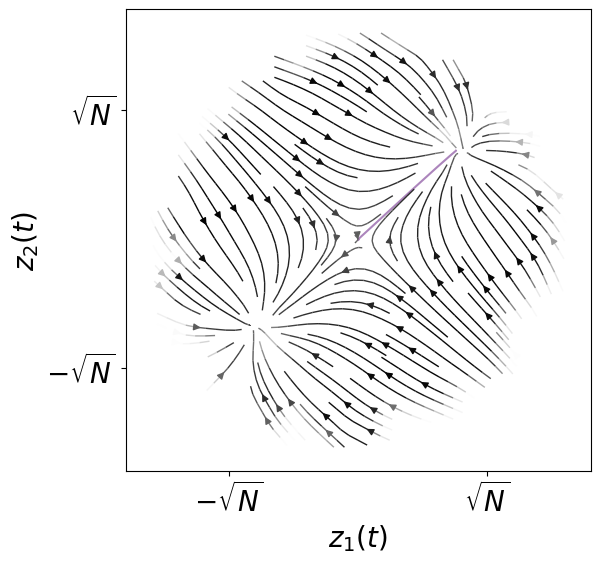

In [52]:
all_batches = Zs[:,0,:,:]

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=Z_long[0])

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, Z_long=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    plt.figure(figsize=(6, 6))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=0.3)
            #plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1.5)
            #break
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=1.5)
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    plt.xlabel('$z_1(t)$', fontsize=20)
    plt.ylabel('$z_2(t)$', fontsize=20)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':

    all_batches = Zs[:,1,:,:]
    
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the flow field for the distinct batches.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
        all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the flow field using a streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=Zs[:,1,:,:], Z_long=Z_long2[1])


IndexError: index 1 is out of bounds for axis 1 with size 1

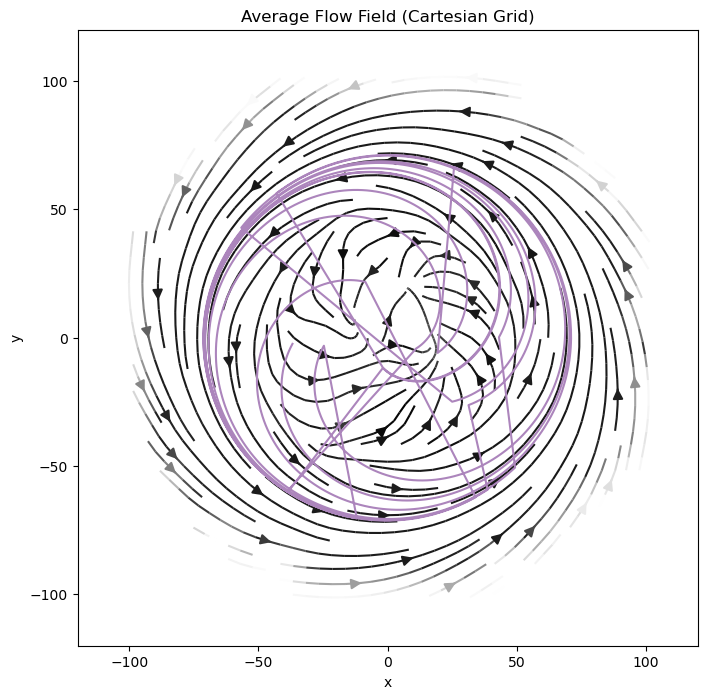

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian(all_series, n_x_bins=20, n_y_bins=20, x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series.

    Parameters:
      all_series : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Create arrays to accumulate velocity sums and counts.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    for series in all_series:
        # Compute finite-difference velocities.
        velocities = np.diff(series, axis=0)
        # Compute midpoints between consecutive points.
        positions = 0.5 * (series[:-1] + series[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if the position is out of the defined range.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Find the corresponding bin indices for x and y.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases where position equals the upper bound.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate velocity and count.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute average velocity where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers from the edges.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # Note: When providing 1D coordinate arrays, U and V need shape (len(y_centers), len(x_centers)).
    # Our U and V are of shape (n_x_bins, n_y_bins), so we transpose them.
    plt.figure(figsize=(8, 8))
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density, color=speed,
                   linewidth=linewidth, arrowsize=arrowsize, cmap='Greys')
    if Z is not None:
        plt.plot(Z[:,0], Z[:,1], color='#AC85BC')
    plt.xlim([np.amin(x_edges), np.amax(x_edges)])
    plt.ylim([np.amin(y_edges), np.amax(y_edges)])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Average Flow Field (Cartesian Grid)')
    #plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':
    
    all_series = [Z[0]]
    # Define Cartesian region of interest.
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the average flow field on the Cartesian grid.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian(
        all_series, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the estimated flow field using streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1.5, arrowsize=1.5,
                                     Z=Z[0,:2000])
    #plt.colorbar()

In [ ]:
#smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][i_sigma_off, i_seed, 0, :], dtype=torch.float32).to(0)
C = torch.tensor(theory_results[1][i_sigma_off, i_seed, 2, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

In [ ]:
Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[0]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

In [ ]:
z_ccov_avg = theory_results[1][i_sigma_off, i_seed, :, :].T
T = z_ccov_T.shape[0]

i_task = 0
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

In [ ]:
acov_T_11.shape

In [ ]:
fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_T_11, color='C0')
ax[0,0].plot(time_vec, acov_avg_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_T_22, color='C0')
ax[1,1].plot(time_vec, acov_avg_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_T_12, color='C0')
ax[0,1].plot(time_vec, ccov_avg_21, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_T_21, color='C0')
ax[1,0].plot(time_vec, ccov_avg_12, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
ax[0,0].legend(['sim', 'theory'])
plt.tight_layout()
fig.savefig('figs/cross_cov_fits.pdf')